In [1]:
#IMPORTS
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
import os
import glob

In [2]:
# TUNING PARAMATERS
epochs = 20
lr = 0.0001
batch_size = 16
img_dims = (96,96,3)

In [3]:
# DATASET
data = []
labels = []

In [4]:
image_files = [f for f in glob.glob(r'Dataset' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [5]:
# CONVERTING IMAGES TO ARRAYS AND LABELLING THE CATEGORIES
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)
    label = img.split(os.path.sep)[-2] 
    if label == "male":
        label = 1
    else:
        label = 0
    labels.append([label]) 

In [6]:
# PRE-PROCESSING
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
# SPLIT DATASET FOR TRAINING AND VALIDATION
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
trainY = to_categorical(trainY, num_classes=2) 
testY = to_categorical(testY, num_classes=2)

In [8]:
# AUGMENTING DATSET 
aug = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
)

In [9]:
# DEFINE MODEL
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first": 
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [10]:
# BUILD MODEL
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

In [11]:
# COMPILE THE MODEL
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [12]:
# EARLY STOPPING
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

In [13]:
# TRAIN THE MODEL
H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size), 
    validation_data=(testX,testY),
    steps_per_epoch=len(trainX) // batch_size, 
    epochs=epochs,
    callbacks=[early_stopping], 
    verbose=1,
)

Epoch 1/20
1000/1000 [==============================] - 385s 385ms/step - loss: 0.7185 - accuracy: 0.6961 - val_loss: 0.4881 - val_accuracy: 0.8130
Epoch 2/20
1000/1000 [==============================] - 401s 401ms/step - loss: 0.5689 - accuracy: 0.7507 - val_loss: 0.5262 - val_accuracy: 0.7713
Epoch 3/20
1000/1000 [==============================] - 407s 407ms/step - loss: 0.4870 - accuracy: 0.7947 - val_loss: 0.3101 - val_accuracy: 0.8848
Epoch 4/20
1000/1000 [==============================] - 430s 430ms/step - loss: 0.4047 - accuracy: 0.8343 - val_loss: 0.2547 - val_accuracy: 0.9147
Epoch 5/20
1000/1000 [==============================] - 393s 393ms/step - loss: 0.3392 - accuracy: 0.8651 - val_loss: 0.2163 - val_accuracy: 0.9277
Epoch 6/20
1000/1000 [==============================] - 381s 381ms/step - loss: 0.3107 - accuracy: 0.8738 - val_loss: 0.1815 - val_accuracy: 0.9367
Epoch 7/20
1000/1000 [==============================] - 392s 392ms/step - loss: 0.2768 - accuracy: 0.8912 - val_

Minimum validation loss: 0.14336012303829193


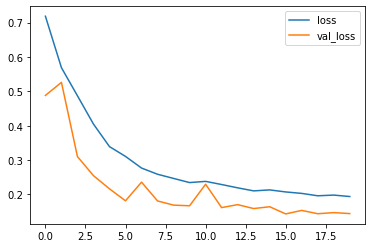

In [19]:
# PLOT TRAINING/VALIDATION ACCURACY
history_df = pd.DataFrame(H.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
plt.savefig('loss.png')

In [15]:
# SAVE THE MODEL TO DISK
model.save('genderDetection.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: genderDetection.model\assets


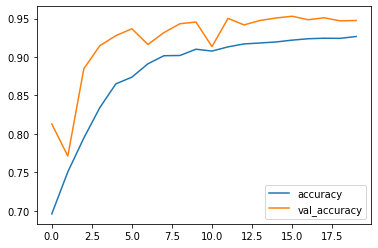

In [20]:
# PLOT TRAINING/VALIDATION ACCURACY
history_df = pd.DataFrame(H.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.savefig('acc.png')